# Stability most sensitive at $N_S = N_R$

This notebook tries to verify the idea that
$$
\rho \geq \sqrt{\min(N_S/N_R, N_R/N_S)},
$$
is the stability criterion.

Moreover, now we try to add cross-feeding, regulation... The Jacobian is given by
$$
   J^* = \left(\begin{array}{c|c}
       O  & D(S^*)(C\odot Y + R^* \cdot H + H\cdot R^*)\\[1.0ex]
     \hline\\[-1.0ex]
     P^T - D(R^*)C^\top   & \left[\frac{\mathrm{d}h}{\mathrm{d}R}\right]- D(C^\top S^*)
    \end{array}
    \right).
$$
The correlation is estimated as
$$
\rho = \sqrt{\frac{1}{\left(1 + \frac{\sigma^2_P}{\mu_R^2\sigma_C^2}\right)\left(1 + \frac{\sigma^2_Y}{\mu_Y^2} 
+ \frac{\sigma^2_Y\mu_C^2}{\sigma^2_C\mu_Y^2} + \frac{2M\sigma^2_H\mu_R^2}{\sigma^2_C\mu_Y^2}\right)}}.
$$

Focus on $Y$ only in this note.

To answer reviewer's question

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First sample communities with constant resource supply.
For first trials, let's play with fixed $\sigma_C$, $\mu_C$, $\mu_R$, $\mu_Y$, but sample with varying $\sigma_P$, $\sigma_Y$, $\sigma_H$.

A function for sampling as follows.

In [2]:
def sample(N:int,
           M:int,
           sigP,
           sigY,
           sigH):
    
       C = np.random.rand(N, M) # 
       muC = 0.5 
       sigC = 1/np.sqrt(12)
       muY = 0.15
       Y = np.random.rand(N, M) * sigY * np.sqrt(12) + muY - sigY * np.sqrt(12) / 2
       H = np.random.randn(N, M, M) * sigH
       P = np.random.rand(N, M) * sigP * np.sqrt(12)
       
       Ss = 0.01 + 0.99*np.random.rand(N)
       Rs = 0.01 + 0.99*np.random.rand(M) #muR = 0.5
       muR = 0.5

       Js = np.zeros((N+M,N+M))
       Js[0:N,N:N+M] = np.diag(Ss) @ (C*Y + np.tensordot(Rs,H, axes=([0],[1])) + np.tensordot(H,Rs, axes=([2],[0])))
       Js[N:N+M,0:N] = P.T - np.diag(Rs) @ C.T
       Js[N:N+M,N:N+M] = - np.diag(C.T @ Ss)

       E_J = np.linalg.eigvals(Js)
       E_Jr = E_J.real
       NU_J = len(E_Jr[E_Jr >= 1.0e-6]) # if devided by Nr or Ns

       rho = np.sqrt(1/(1 + sigP**2/muR**2/sigC**2)/(1 + sigY**2/muY**2 + sigY**2*muC**2/muY**2/sigC**2 + 2*M*sigH**2*muR**2/sigC**2/muY**2))

       return NU_J, rho

Try to sample some points to determine resonable ranges for sigmas

In [3]:
M = 32
N_span = range(1,129,2)
NU = np.zeros((len(N_span), 1000))
rhos = np.zeros((len(N_span), 1000))

In [4]:
for i in range(len(N_span)):
    N = N_span[i]
    for jY in range(1,1001):
        sigY = np.linspace(0, 0.3/np.sqrt(12), 1000)[jY-1]
        NU[i,jY-1], rhos[i,jY-1] = sample(N,M,0,sigY,0)

In [5]:
FNC = (NU > 0).astype(float)
NvM = np.transpose(N_span * np.ones((1000,len(N_span))), (1,0))/M

In [6]:
def criterion(x):
    # x is Ns/Nr array
    y = np.minimum(np.sqrt(x), np.sqrt(1/x))
    return y

xdraw = np.linspace(0.001, 4)
ydraw = criterion(xdraw)

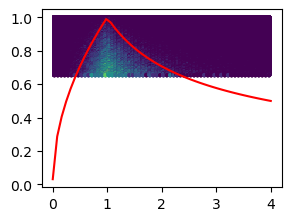

In [7]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
plt.scatter(NvM, rhos, c=NU, s=5)
plt.plot(xdraw, ydraw, 'r')

In [8]:
dx = 1.01/16
dy = 0.01
xgrids = np.arange(0,4,dx)
ygrids = np.arange(0,1,dy)
FUC_heat = np.zeros((len(ygrids), len(xgrids)))
count = np.ones((len(ygrids), len(xgrids)))
for i in range(rhos.shape[0]):
    for jY in range(rhos.shape[1]):
        xx = int(NvM[i,jY]/dx)
        yy = int(rhos[i,jY]/dy)
        FUC_heat[len(ygrids) - 1 - yy, xx] = (FUC_heat[len(ygrids) - 1 - yy, xx] * (count[len(ygrids) - 1 - yy, xx] - 1) \
            + FNC[i,jY]) / count[len(ygrids) - 1 - yy, xx]
        count[len(ygrids) - 1 - yy, xx] = count[len(ygrids) - 1 - yy, xx] + 1.0

In [9]:
np.min(rhos)

0.6546536707079772

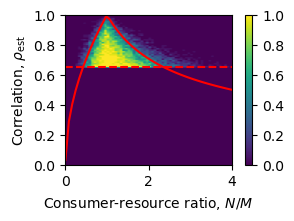

In [11]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
extent = .0, 4, 0, 1
plt.imshow(FUC_heat, extent=extent, aspect=3.6)
plt.colorbar()
plt.plot(xdraw, ydraw, 'r')
plt.plot(np.linspace(0,4), np.ones(50)*np.min(rhos), 'r--')

plt.xlabel('Consumer-resource ratio, $N/M$')
plt.ylabel(r'Correlation, $\rho_{\rm est}$')
plt.savefig('../figures/SI7.pdf')